In [1]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,BaggingClassifier,ExtraTreesClassifier,GradientBoostingClassifier
import numpy as np
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier

In [2]:
%matplotlib inline
import os
import operator
import numpy as np
import pandas as pd
from football_loader import metrics




In [3]:
league = 'english'
validate_year = 2016
test_year = 2017
train_year = 2005
df = load_league_csv(league)

In [4]:
teams = df.loc[(df['Year'] == validate_year) | (df['Year'] == test_year), 'HomeTeam']
teams = teams.unique()
teams.sort()
print(teams)
print(len(teams))

['Arsenal' 'Bournemouth' 'Brighton' 'Burnley' 'Chelsea' 'Crystal Palace'
 'Everton' 'Huddersfield' 'Hull' 'Leicester' 'Liverpool' 'Man City'
 'Man United' 'Middlesbrough' 'Newcastle' 'Southampton' 'Stoke'
 'Sunderland' 'Swansea' 'Tottenham' 'Watford' 'West Brom' 'West Ham']
23


In [5]:
teams = make_features(df, teams)
classes = ['Draw', 'Lose', 'Win']

In [6]:
print('X')
print(teams[next(iter(teams))][0].count()) # X
print('Y')
print(teams[next(iter(teams))][1].count()) # Y
print(len(teams), 'teams')

X
Year                            504
HomeMatch                       504
B365Say                         504
B365Diff                        504
Last5AgainstThisOpponentWon     504
Last5AgainstThisOpponentDraw    504
Last3AgainstThisOpponentWon     504
Last3AgainstThisOpponentDraw    504
LastAgainstThisOpponentWon      504
LastAgainstThisOpponentDraw     504
PointsSoFar                     504
AdjustedPointsSoFar             504
Last5Won                        504
Last5Draw                       504
Last3Won                        504
Last3Draw                       504
LastWon                         504
LastDraw                        504
dtype: int64
Y
Result    504
dtype: int64
23 teams


In [7]:
total = None
for team in teams:
# for team in ['Arsenal']:
    X = teams[team][0]
    Y = teams[team][1]
    # split data into train - validate - test sets
    x_train = X[(X['Year'] >= train_year) & (X['Year'] < validate_year)]
    y_train = Y[(X['Year'] >= train_year) & (X['Year'] < validate_year)]
    x_validate = X[(X['Year'] >= validate_year) & (X['Year'] < test_year)]
    y_validate = Y[(X['Year'] >= validate_year) & (X['Year'] < test_year)]
    x_test = X[(X['Year'] >= test_year)]
    y_test = Y[(X['Year'] >= test_year)]
    if len(x_train) <= 0 or len(x_test) <= 0 or len(x_validate) <= 0:
        print(f'skip {team}')
        continue
    
    validate_accuracies = {}
    test_accuracies = {}
    
    lr = LogisticRegression()
    lr.fit(x_train, y_train['Result'])
    y_validate_pred = lr.predict(x_validate)
    validate_accuracies['LogisticRegression'] = accuracy_score(y_validate, y_validate_pred) * 100
    y_test_pred = lr.predict(x_test)
    test_accuracies['LogisticRegression'] = accuracy_score(y_test, y_test_pred) * 100
    y_validate_prob = lr.predict_proba(x_validate)
    y_test_prob = lr.predict_proba(x_test)
#     print(y_validate_prob)
#     print(y_test_prob)
    prob = np.vstack((y_validate_prob, y_test_prob))
#     print(prob)
#     print(prob[:,0])
#     print(np.max(prob, axis=1))
#     print(np.min(prob, axis=1))
    d = pd.DataFrame(
        data={
            'Year': x_validate['Year'].append(x_test['Year']),
            'Team': team,
            'Predict': np.append(y_validate_pred, y_test_pred),
            'Actual': y_validate['Result'].append(y_test['Result']),
            'DrawProb': prob[:,0],
            'LoseProb': prob[:,1],
            'WinProb': prob[:,2],
            'MaxProb': np.max(prob, axis=1),
            'MinProb': np.min(prob, axis=1)
        },
        index=np.append(y_validate.index, y_test.index)
#         index=pd.MultiIndex.from_tuples(
#             list(zip(np.repeat('LogisticRegression', len(y_test.index)), y_test.index.values)),
#             names=['predictor', 'match_id'])
    )
    if total is None:
        total = d
    else:
        total = total.append(d)
    for (k, v) in validate_accuracies.items():
        print(f"{k}: {team} validation accuracy are: {v}")
#         cm = confusion_matrix(y_validate, y_validate_pred, labels=classes)
#         metrics.plot_confusion_matrix(cm, classes, title=team)
        print(f"{k}: {team} test accuracy are: {test_accuracies[k]}")
#         cm = confusion_matrix(y_test, y_test_pred, labels=classes)
#         metrics.plot_confusion_matrix(cm, classes, title=team)
#     print(lr.coef_)
    



LogisticRegression: Arsenal validation accuracy are: 63.1578947368421
LogisticRegression: Arsenal test accuracy are: 68.75
LogisticRegression: Bournemouth validation accuracy are: 55.26315789473685
LogisticRegression: Bournemouth test accuracy are: 43.75
skip Brighton
LogisticRegression: Burnley validation accuracy are: 52.63157894736842
LogisticRegression: Burnley test accuracy are: 33.33333333333333
LogisticRegression: Chelsea validation accuracy are: 76.31578947368422
LogisticRegression: Chelsea test accuracy are: 56.25
LogisticRegression: Crystal Palace validation accuracy are: 42.10526315789473
LogisticRegression: Crystal Palace test accuracy are: 56.25
LogisticRegression: Everton validation accuracy are: 42.10526315789473
LogisticRegression: Everton test accuracy are: 62.5
skip Huddersfield
skip Hull
LogisticRegression: Leicester validation accuracy are: 44.73684210526316
LogisticRegression: Leicester test accuracy are: 41.66666666666667
LogisticRegression: Liverpool validation a

In [8]:
# for key, groupByPredictor in total.groupby('predictor'):
#     print(f"{key} overall accuracy is ", accuracy_score(groupByPredictor['actual'], groupByPredictor['pred'])*100)
print(f"Overall accuracy is ", accuracy_score(total['Actual'], total['Predict'])*100)

Overall accuracy is  53.282122905027926


In [9]:
total

,Year,Team,Predict,Actual,DrawProb,LoseProb,WinProb,MaxProb,MinProb
4188,2016,Arsenal,Win,Lose,0.316565,0.328488,0.354947,0.354947,0.316565
4193,2016,Arsenal,Win,Draw,0.110751,0.275762,0.613487,0.613487,0.110751
4208,2016,Arsenal,Win,Win,0.113265,0.112294,0.774441,0.774441,0.112294
4211,2016,Arsenal,Win,Win,0.210043,0.168098,0.621858,0.621858,0.168098
4223,2016,Arsenal,Win,Win,0.243385,0.129175,0.627439,0.627439,0.129175
4231,2016,Arsenal,Draw,Win,0.370889,0.310069,0.319042,0.370889,0.310069
4247,2016,Arsenal,Win,Win,0.071672,0.108559,0.819769,0.819769,0.071672
4251,2016,Arsenal,Win,Win,0.177462,0.110695,0.711843,0.711843,0.110695
4261,2016,Arsenal,Win,Draw,0.055047,0.027553,0.917400,0.917400,0.027553
4274,2016,Arsenal,Win,Win,0.185684,0.178488,0.635828,0.635828,0.178488


In [10]:
chart_data = {}
chart_data_all = None
for team, dataset in teams.items():
    chart_data_team = pd.DataFrame(dataset[0])
    chart_data_team = chart_data_team[(chart_data_team['Year'] >= validate_year) | (chart_data_team['Year'] >= test_year)]
    chart_data_team['Actual'] = dataset[1]['Result']
    i = total[(total.index.isin(chart_data_team.index)) & (total['Team'] == team)]
    chart_data_team.loc[i.index, 'Predict'] = i['Predict']
    chart_data_team['Point'] = np.where(chart_data_team['Actual'] == 'Win', 3,
                                 np.where(chart_data_team['Actual'] == 'Draw', 1, 0)
                                  )
    chart_data_team['PointPredict'] = np.where(chart_data_team['Predict'] == 'Win', 3,
                                 np.where(chart_data_team['Predict'] == 'Draw', 1, 0)
                                  )
    for key, groupByYear in chart_data_team.groupby('Year'):
        chart_data_team.loc[groupByYear.index, 'MatchNo'] = range(1,len(groupByYear['Actual'])+1)
        chart_data_team.loc[groupByYear.index, 'TotalPoints'] = np.nancumsum(groupByYear['Point'])
        chart_data_team.loc[groupByYear.index, 'TotalPointsPredict'] = np.nancumsum(groupByYear['PointPredict'])
        
    chart_data_team['Team'] = team
    chart_data[team] = chart_data_team
    if chart_data_all is None:
        chart_data_all = chart_data_team
    else:
        chart_data_all = chart_data_all.append(chart_data_team, ignore_index=True, sort=False)
chart_data_all

,Year,HomeMatch,B365Say,B365Diff,Last5AgainstThisOpponentWon,Last5AgainstThisOpponentDraw,Last3AgainstThisOpponentWon,Last3AgainstThisOpponentDraw,LastAgainstThisOpponentWon,LastAgainstThisOpponentDraw,...,LastWon,LastDraw,Actual,Predict,Point,PointPredict,MatchNo,TotalPoints,TotalPointsPredict,Team
0,2016,True,0,-0.70,1.0,3.0,1.0,2.0,0.0,1.0,...,1.0,0.0,Lose,Win,0,3,1.0,0.0,3.0,Arsenal
1,2016,False,0,-0.38,0.0,0.0,3.0,0.0,1.0,0.0,...,0.0,0.0,Draw,Win,1,3,2.0,1.0,6.0,Arsenal
2,2016,False,1,3.27,0.0,0.0,3.0,0.0,1.0,0.0,...,0.0,1.0,Win,Win,3,3,3.0,4.0,9.0,Arsenal
3,2016,True,1,4.93,1.0,2.0,0.0,1.0,0.0,1.0,...,1.0,0.0,Win,Win,3,3,4.0,7.0,12.0,Arsenal
4,2016,False,1,4.40,4.0,1.0,2.0,1.0,1.0,0.0,...,1.0,0.0,Win,Win,3,3,5.0,10.0,15.0,Arsenal
5,2016,True,0,-0.70,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,Win,Draw,3,1,6.0,13.0,16.0,Arsenal
6,2016,False,1,7.60,0.0,0.0,3.0,0.0,1.0,0.0,...,1.0,0.0,Win,Win,3,3,7.0,16.0,19.0,Arsenal
7,2016,True,1,9.71,1.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,Win,Win,3,3,8.0,19.0,22.0,Arsenal
8,2016,True,1,13.75,1.0,3.0,1.0,2.0,1.0,0.0,...,1.0,0.0,Draw,Win,1,3,9.0,20.0,25.0,Arsenal
9,2016,False,1,7.60,3.0,2.0,1.0,2.0,0.0,1.0,...,0.0,1.0,Win,Win,3,3,10.0,23.0,28.0,Arsenal


In [11]:
fixtures = pd.DataFrame(df[df['Year'] == test_year])
fixtures['Date'] = pd.to_datetime(fixtures['Date'], dayfirst=True)
fixtures.sort_values(['Date'], inplace=True)
# fixtures.dropna(subset=['Year'], inplace=True)
fixtures

,index,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,Match,BSH,BSD,BSA,PSH,PSD,PSA,PSCH,PSCD,PSCA
4561,4561,E0,2017-08-11,Arsenal,Leicester,4.0,3.0,H,2.0,2.0,...,1,NaN,NaN,NaN,1.53,4.55,6.85,1.49,4.73,7.25
4562,4562,E0,2017-08-12,Brighton,Man City,0.0,2.0,A,0.0,0.0,...,2,NaN,NaN,NaN,10.95,5.55,1.34,11.75,6.15,1.29
4563,4563,E0,2017-08-12,Chelsea,Burnley,2.0,3.0,A,0.0,3.0,...,3,NaN,NaN,NaN,1.26,6.30,15.25,1.33,5.40,12.25
4564,4564,E0,2017-08-12,Crystal Palace,Huddersfield,0.0,3.0,A,0.0,2.0,...,4,NaN,NaN,NaN,1.83,3.58,5.11,1.79,3.56,5.51
4565,4565,E0,2017-08-12,Everton,Stoke,1.0,0.0,H,1.0,0.0,...,5,NaN,NaN,NaN,1.70,3.83,5.81,1.82,3.49,5.42
4566,4566,E0,2017-08-12,Southampton,Swansea,0.0,0.0,D,0.0,0.0,...,6,NaN,NaN,NaN,1.64,3.94,6.35,1.56,4.25,6.85
4567,4567,E0,2017-08-12,Watford,Liverpool,3.0,3.0,D,2.0,1.0,...,7,NaN,NaN,NaN,5.74,4.29,1.63,6.88,4.27,1.56
4568,4568,E0,2017-08-12,West Brom,Bournemouth,1.0,0.0,H,1.0,0.0,...,8,NaN,NaN,NaN,2.46,3.25,3.26,2.65,3.21,3.02
4569,4569,E0,2017-08-13,Man United,West Ham,4.0,0.0,H,1.0,0.0,...,9,NaN,NaN,NaN,1.33,5.68,10.85,1.31,5.79,12.01
4570,4570,E0,2017-08-13,Newcastle,Tottenham,0.0,2.0,A,0.0,0.0,...,10,NaN,NaN,NaN,5.35,4.00,1.71,4.82,3.90,1.80


In [1]:
fixtures

NameError: name 'fixtures' is not defined

In [12]:
def naive_method(fixtures, starting_balance=1000):
    # naive method
#     starting_balance = 1000
    balance = starting_balance
    bet = -50
    balances = []
    dates = []
    print("Starting balance:", balance)
    for date, groupByDate in fixtures.groupby('Date'):
        for _, match in groupByDate.iterrows():
    #         print(match['index'])
            d = date.date().strftime('%Y-%m-%d')
            predictions = total[total.index == match['index']]
            if (len(predictions) == 1):
    #             prediction = predictions[:,0]
    #             print(predictions)
                team = predictions['Team'].values[0]
                pred = predictions['Predict'].values[0]
                act = predictions['Actual'].values[0]
                balance += bet
                print(d, "Pay:", bet, 'on', team, 'in [', match['HomeTeam'], 'vs', match['AwayTeam'], "] Pred:", pred, "Actual:", act, 'Balance:', balance)
                
                odd = 0
                if pred == act:
    #                 print(match)
                    if pred == act == 'Draw':
                        odd = match['B365D']
                    elif match['HomeTeam'] == team:
                        odd = match['B365H']
                    else:
                        odd = match['B365A']
                    receive = bet * odd * -1
                    balance += receive
                    print(d, "Receive:", receive, "Odd:", odd, "Balance:", balance)
            elif (len(predictions) == 2):
    #             print(predictions)
    #             print(match)
                pred_one = predictions['Predict'].values[0]
                pred_two = predictions['Predict'].values[1]
                act_one = predictions['Actual'].values[0]
                act_two = predictions['Actual'].values[1]
    #             print(team, "Pred: ", pred, "Actual:", act)

                # unanimousness
                if (pred_one == pred_two == 'Draw') or\
                (pred_one == 'Win' and pred_two == 'Lose') or\
                (pred_one == 'Lose' and pred_two == 'Win'):

                    balance += bet
#                     print('what', len(predictions), balance)
#                     print(match)
                    odd = 0

                    if pred_one == pred_two == act_one == act_two == 'Draw':
                        team = predictions['Team'].values[0]
                        odd = match['B365D']
                        print(d, "Pay:", bet, 'on', team, 'in [', match['HomeTeam'], 'vs', match['AwayTeam'], "] Pred:", pred, "Actual:", act, 'Balance:', balance)

                    elif pred_one == act_one == 'Win' and pred_two == act_two == 'Lose':
                        team = predictions['Team'].values[0]
                        if match['HomeTeam'] == team:
                            odd = match['B365H']
                        else:
                            odd = match['B365A']
                        print(d, "Pay:", bet, 'on', team, 'in [', match['HomeTeam'], 'vs', match['AwayTeam'], "] Pred:", pred_one, "Actual:", act_one, 'Balance:', balance)

                    elif pred_one == act_one == 'Lose' and pred_two == act_two == 'Win':
                        team = predictions['Team'].values[1]
                        if match['HomeTeam'] == team:
                            odd = match['B365H']
                        else:
                            odd = match['B365A']
                        print(d, "Pay:", bet, 'on', team, 'in [', match['HomeTeam'], 'vs', match['AwayTeam'], "] Pred:", pred_two, "Actual:", act_two, 'Balance:', balance)
                    else:
                        team = predictions['Team'].values[0]
                        print(d, "Pay:", bet, 'on', team, 'in [', match['HomeTeam'], 'vs', match['AwayTeam'], "] Pred:", pred_one, "Actual:", act_one, 'Balance:', balance)
                    
                    if odd != 0:
                        receive = bet * odd * -1
                        balance += receive
                        print(d, "Receive:", receive, "Odd:", odd, "Balance:", balance)

            else:
                print(d, "No bet in [", match['HomeTeam'], 'vs', match['AwayTeam'], "] Balance:", balance)
    #             print(predictions)
        balances.append(balance)
        dates.append(date)
    print("Ending balance:", balance)
    year = dates[0].date().year
    df_sim = pd.DataFrame(
    data={
        'Date': dates,
        'Balance': balances,
        'Year': year,
        'MatchDay': range(0, len(dates))
    })
    return df_sim

df_sim = naive_method(fixtures)

Starting balance: 1000
2017-08-11 Pay: -50 on Arsenal in [ Arsenal vs Leicester ] Pred: Win Actual: Win Balance: 950
2017-08-11 Receive: 76.5 Odd: 1.53 Balance: 1026.5
2017-08-12 Pay: -50 on Man City in [ Brighton vs Man City ] Pred: Win Actual: Win Balance: 976.5
2017-08-12 Receive: 66.5 Odd: 1.33 Balance: 1043.0
2017-08-12 Pay: -50 on Crystal Palace in [ Crystal Palace vs Huddersfield ] Pred: Lose Actual: Lose Balance: 993.0
2017-08-12 Receive: 91.5 Odd: 1.83 Balance: 1084.5
2017-08-12 Pay: -50 on Everton in [ Everton vs Stoke ] Pred: Win Actual: Win Balance: 1034.5
2017-08-12 Receive: 85.0 Odd: 1.7 Balance: 1119.5
2017-08-12 Pay: -50 on Southampton in [ Southampton vs Swansea ] Pred: Win Actual: Draw Balance: 1069.5
2017-08-12 Pay: -50 on Liverpool in [ Watford vs Liverpool ] Pred: Win Actual: Draw Balance: 1019.5
2017-08-13 Pay: -50 on Man United in [ Man United vs West Ham ] Pred: Win Actual: Win Balance: 969.5
2017-08-13 Receive: 65.0 Odd: 1.3 Balance: 1034.5
2017-08-13 Pay: -50 

2017-10-28 Pay: -50 on Man City in [ West Brom vs Man City ] Pred: Win Actual: Win Balance: 1246.0
2017-10-28 Receive: 64.0 Odd: 1.28 Balance: 1310.0
2017-10-28 Pay: -50 on Man United in [ Man United vs Tottenham ] Pred: Win Actual: Win Balance: 1260.0
2017-10-28 Receive: 107.0 Odd: 2.14 Balance: 1367.0
2017-10-28 Pay: -50 on Liverpool in [ Liverpool vs Huddersfield ] Pred: Win Actual: Win Balance: 1317.0
2017-10-28 Receive: 62.5 Odd: 1.25 Balance: 1379.5
2017-10-28 Pay: -50 on Chelsea in [ Bournemouth vs Chelsea ] Pred: Win Actual: Win Balance: 1329.5
2017-10-28 Receive: 80.5 Odd: 1.61 Balance: 1410.0
2017-10-28 Pay: -50 on Arsenal in [ Arsenal vs Swansea ] Pred: Win Actual: Win Balance: 1360.0
2017-10-28 Receive: 62.5 Odd: 1.25 Balance: 1422.5
2017-10-29 Pay: -50 on Southampton in [ Brighton vs Southampton ] Pred: Win Actual: Draw Balance: 1372.5
2017-10-29 Pay: -50 on Leicester in [ Leicester vs Everton ] Pred: Win Actual: Win Balance: 1322.5
2017-10-29 Receive: 107.0 Odd: 2.14 Bala

2017-12-27 Receive: 62.5 Odd: 1.25 Balance: 1279.5
2017-12-28 Pay: -50 on Arsenal in [ Crystal Palace vs Arsenal ] Pred: Win Actual: Win Balance: 1229.5
2017-12-28 Receive: 90.0 Odd: 1.8 Balance: 1319.5
2017-12-30 Pay: -50 on Bournemouth in [ Bournemouth vs Everton ] Pred: Win Actual: Win Balance: 1269.5
2017-12-30 Receive: 118.5 Odd: 2.37 Balance: 1388.0
2017-12-30 Pay: -50 on Chelsea in [ Chelsea vs Stoke ] Pred: Win Actual: Win Balance: 1338.0
2017-12-30 Receive: 57.99999999999999 Odd: 1.16 Balance: 1396.0
2017-12-30 Pay: -50 on Burnley in [ Huddersfield vs Burnley ] Pred: Lose Actual: Draw Balance: 1346.0
2017-12-30 Pay: -50 on Liverpool in [ Liverpool vs Leicester ] Pred: Win Actual: Win Balance: 1296.0
2017-12-30 Receive: 65.0 Odd: 1.3 Balance: 1361.0
2017-12-30 Pay: -50 on Man United in [ Man United vs Southampton ] Pred: Win Actual: Draw Balance: 1311.0
2017-12-30 No bet in [ Newcastle vs Brighton ] Balance: 1311.0
2017-12-30 Pay: -50 on Swansea in [ Watford vs Swansea ] Pred: 

2018-03-31 Pay: -50 on Bournemouth in [ Watford vs Bournemouth ] Pred: Win Actual: Draw Balance: 1160.5
2018-03-31 No bet in [ Newcastle vs Huddersfield ] Balance: 1160.5
2018-03-31 Pay: -50 on Man United in [ Man United vs Swansea ] Pred: Win Actual: Win Balance: 1110.5
2018-03-31 Receive: 62.5 Odd: 1.25 Balance: 1173.0
2018-03-31 Pay: -50 on Man City in [ Everton vs Man City ] Pred: Win Actual: Win Balance: 1123.0
2018-03-31 Receive: 66.5 Odd: 1.33 Balance: 1189.5
2018-03-31 Pay: -50 on Liverpool in [ Crystal Palace vs Liverpool ] Pred: Win Actual: Win Balance: 1139.5
2018-03-31 Receive: 72.0 Odd: 1.44 Balance: 1211.5
2018-03-31 Pay: -50 on Leicester in [ Brighton vs Leicester ] Pred: Win Actual: Win Balance: 1161.5
2018-03-31 Receive: 131.0 Odd: 2.62 Balance: 1292.5
2018-04-07 Pay: -50 on Man City in [ Man City vs Man United ] Pred: Win Actual: Lose Balance: 1242.5
2018-04-07 No bet in [ Brighton vs Huddersfield ] Balance: 1242.5
2018-04-07 Pay: -50 on Leicester in [ Leicester vs Ne

In [13]:
df_sim

,Date,Balance,Year,MatchDay
0,2017-08-11,1026.5,2017,0
1,2017-08-12,1019.5,2017,1
2,2017-08-13,1069.5,2017,2
3,2017-08-19,1005.5,2017,3
4,2017-08-20,955.5,2017,4
5,2017-08-21,905.5,2017,5
6,2017-08-26,957.0,2017,6
7,2017-08-27,929.5,2017,7
8,2017-09-09,1067.0,2017,8
9,2017-09-10,1017.0,2017,9


1626.5
610.0


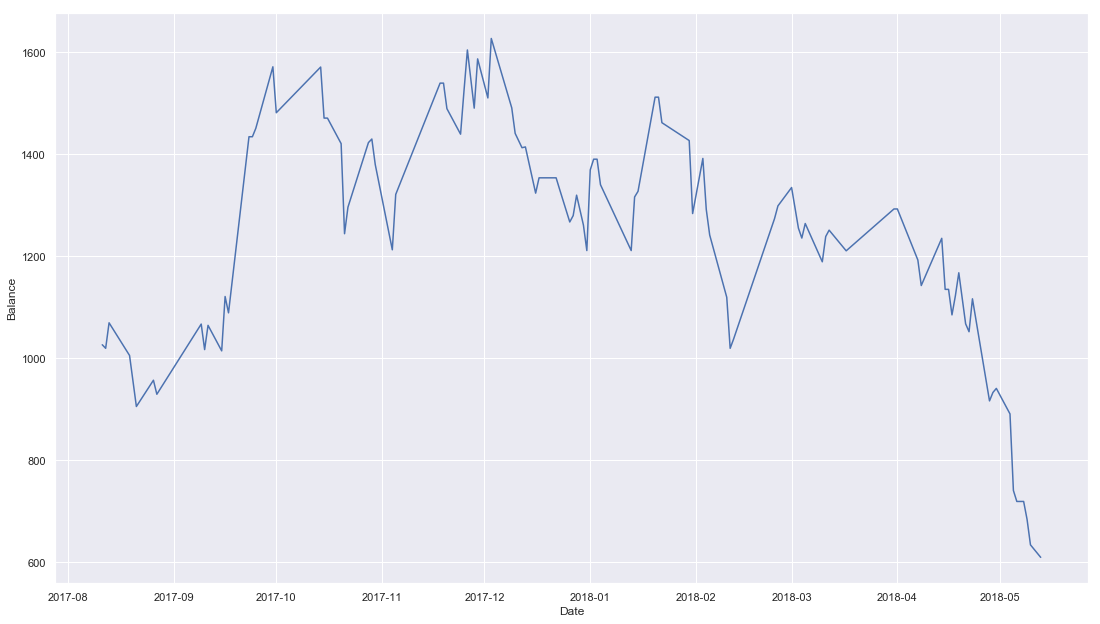

In [14]:
%matplotlib inline
import seaborn as sns
sns.set()
print(max(df_sim['Balance']))
print(min(df_sim['Balance']))
g = sns.lineplot(data=df_sim, x='Date', y='Balance')
g.figure.set_size_inches(18.5, 10.5)

In [15]:
fixtures_2016 = pd.DataFrame(df[df['Year'] == validate_year])
fixtures_2016['Date'] = pd.to_datetime(fixtures_2016['Date'], dayfirst=True)
fixtures_2016.sort_values(['Date'], inplace=True)
# fixtures_2016.dropna(subset=['Year'], inplace=True)
fixtures_2016
df_sim_2016 = naive_method(fixtures_2016)
df_sim_2016

Starting balance: 1000
2016-08-13 Pay: -50 on West Brom in [ Crystal Palace vs West Brom ] Pred: Win Actual: Win Balance: 950
2016-08-13 Receive: 225.0 Odd: 4.5 Balance: 1175.0
2016-08-13 Pay: -50 on Everton in [ Everton vs Tottenham ] Pred: Lose Actual: Draw Balance: 1125.0
2016-08-13 Pay: -50 on Leicester in [ Hull vs Leicester ] Pred: Win Actual: Lose Balance: 1075.0
2016-08-13 Pay: -50 on Man City in [ Man City vs Sunderland ] Pred: Win Actual: Win Balance: 1025.0
2016-08-13 Receive: 62.5 Odd: 1.25 Balance: 1087.5
2016-08-13 Pay: -50 on Stoke in [ Middlesbrough vs Stoke ] Pred: Lose Actual: Draw Balance: 1037.5
2016-08-13 Pay: -50 on Southampton in [ Southampton vs Watford ] Pred: Win Actual: Draw Balance: 987.5
2016-08-14 Pay: -50 on Man United in [ Bournemouth vs Man United ] Pred: Win Actual: Win Balance: 937.5
2016-08-14 Receive: 92.5 Odd: 1.85 Balance: 1030.0
2016-08-15 Pay: -50 on Chelsea in [ Chelsea vs West Ham ] Pred: Win Actual: Win Balance: 980.0
2016-08-15 Receive: 82.5

2016-11-26 Pay: -50 on Chelsea in [ Chelsea vs Tottenham ] Pred: Win Actual: Win Balance: 1741.0
2016-11-26 Receive: 87.5 Odd: 1.75 Balance: 1828.5
2016-11-26 Pay: -50 on West Brom in [ Hull vs West Brom ] Pred: Lose Actual: Draw Balance: 1778.5
2016-11-26 Pay: -50 on Leicester in [ Leicester vs Middlesbrough ] Pred: Win Actual: Draw Balance: 1728.5
2016-11-26 Pay: -50 on Liverpool in [ Liverpool vs Sunderland ] Pred: Win Actual: Win Balance: 1678.5
2016-11-26 Receive: 58.5 Odd: 1.17 Balance: 1737.0
2016-11-27 Pay: -50 on Arsenal in [ Arsenal vs Bournemouth ] Pred: Win Actual: Win Balance: 1687.0
2016-11-27 Receive: 70.0 Odd: 1.4 Balance: 1757.0
2016-11-27 Pay: -50 on Man United in [ Man United vs West Ham ] Pred: Win Actual: Draw Balance: 1707.0
2016-12-03 Pay: -50 on Arsenal in [ West Ham vs Arsenal ] Pred: Win Actual: Win Balance: 1657.0
2016-12-03 Receive: 87.5 Odd: 1.75 Balance: 1744.5
2016-12-03 Pay: -50 on Tottenham in [ Tottenham vs Swansea ] Pred: Win Actual: Win Balance: 1694

2017-01-31 Pay: -50 on Southampton in [ Swansea vs Southampton ] Pred: Win Actual: Lose Balance: 1446.0
2017-02-01 Pay: -50 on Man United in [ Man United vs Hull ] Pred: Win Actual: Draw Balance: 1396.0
2017-02-01 Pay: -50 on Man City in [ West Ham vs Man City ] Pred: Win Actual: Win Balance: 1346.0
2017-02-01 Receive: 78.5 Odd: 1.57 Balance: 1424.5
2017-02-04 Pay: -50 on Watford in [ Watford vs Burnley ] Pred: Win Actual: Win Balance: 1374.5
2017-02-04 Receive: 107.5 Odd: 2.15 Balance: 1482.0
2017-02-04 Pay: -50 on Tottenham in [ Tottenham vs Middlesbrough ] Pred: Win Actual: Win Balance: 1432.0
2017-02-04 Receive: 64.5 Odd: 1.29 Balance: 1496.5
2017-02-04 Pay: -50 on Southampton in [ Southampton vs West Ham ] Pred: Win Actual: Lose Balance: 1446.5
2017-02-04 Pay: -50 on Everton in [ Everton vs Bournemouth ] Pred: Win Actual: Win Balance: 1396.5
2017-02-04 Receive: 85.0 Odd: 1.7 Balance: 1481.5
2017-02-04 Pay: -50 on Crystal Palace in [ Crystal Palace vs Sunderland ] Pred: Win Actual:

2017-04-17 Pay: -50 on Arsenal in [ Middlesbrough vs Arsenal ] Pred: Win Actual: Win Balance: 1836.5
2017-04-17 Receive: 75.0 Odd: 1.5 Balance: 1911.5
2017-04-22 Pay: -50 on Bournemouth in [ Bournemouth vs Middlesbrough ] Pred: Win Actual: Win Balance: 1861.5
2017-04-22 Receive: 92.5 Odd: 1.85 Balance: 1954.0
2017-04-22 Pay: -50 on Watford in [ Hull vs Watford ] Pred: Lose Actual: Lose Balance: 1904.0
2017-04-22 Receive: 216.5 Odd: 4.33 Balance: 2120.5
2017-04-23 Pay: -50 on Man United in [ Burnley vs Man United ] Pred: Win Actual: Win Balance: 2070.5
2017-04-23 Receive: 83.5 Odd: 1.67 Balance: 2154.0
2017-04-23 Pay: -50 on Crystal Palace in [ Liverpool vs Crystal Palace ] Pred: Lose Actual: Win Balance: 2104.0
2017-04-25 Pay: -50 on Chelsea in [ Chelsea vs Southampton ] Pred: Win Actual: Win Balance: 2054.0
2017-04-25 Receive: 72.5 Odd: 1.45 Balance: 2126.5
2017-04-26 No bet in [ Middlesbrough vs Sunderland ] Balance: 2126.5
2017-04-26 Pay: -50 on Tottenham in [ Crystal Palace vs Tott

,Date,Balance,Year,MatchDay
0,2016-08-13,987.5,2016,0
1,2016-08-14,1030.0,2016,1
2,2016-08-15,1062.5,2016,2
3,2016-08-19,1089.0,2016,3
4,2016-08-20,1048.0,2016,4
5,2016-08-21,1095.5,2016,5
6,2016-08-27,1066.5,2016,6
7,2016-08-28,1029.0,2016,7
8,2016-09-10,995.0,2016,8
9,2016-09-11,995.0,2016,9


2469.0
987.5


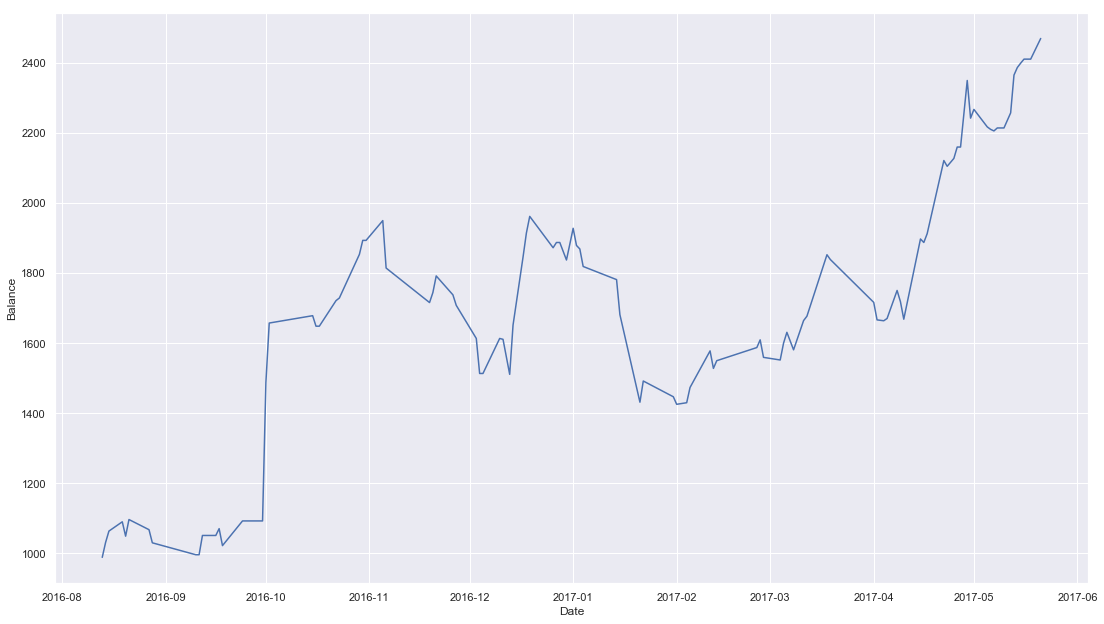

In [16]:
%matplotlib inline
import seaborn as sns
sns.set()
print(max(df_sim_2016['Balance']))
print(min(df_sim_2016['Balance']))
g = sns.lineplot(data=df_sim_2016, x='Date', y='Balance')
g.figure.set_size_inches(18.5, 10.5)

Starting balance: 1000
2016-08-13 Pay: -50 on West Brom in [ Crystal Palace vs West Brom ] Pred: Win Actual: Win Balance: 950
2016-08-13 Receive: 225.0 Odd: 4.5 Balance: 1175.0
2016-08-13 Pay: -50 on Everton in [ Everton vs Tottenham ] Pred: Lose Actual: Draw Balance: 1125.0
2016-08-13 Pay: -50 on Leicester in [ Hull vs Leicester ] Pred: Win Actual: Lose Balance: 1075.0
2016-08-13 Pay: -50 on Man City in [ Man City vs Sunderland ] Pred: Win Actual: Win Balance: 1025.0
2016-08-13 Receive: 62.5 Odd: 1.25 Balance: 1087.5
2016-08-13 Pay: -50 on Stoke in [ Middlesbrough vs Stoke ] Pred: Lose Actual: Draw Balance: 1037.5
2016-08-13 Pay: -50 on Southampton in [ Southampton vs Watford ] Pred: Win Actual: Draw Balance: 987.5
2016-08-14 Pay: -50 on Man United in [ Bournemouth vs Man United ] Pred: Win Actual: Win Balance: 937.5
2016-08-14 Receive: 92.5 Odd: 1.85 Balance: 1030.0
2016-08-15 Pay: -50 on Chelsea in [ Chelsea vs West Ham ] Pred: Win Actual: Win Balance: 980.0
2016-08-15 Receive: 82.5

2016-11-20 Receive: 78.5 Odd: 1.57 Balance: 1743.5
2016-11-21 Pay: -50 on West Brom in [ West Brom vs Burnley ] Pred: Win Actual: Win Balance: 1693.5
2016-11-21 Receive: 97.5 Odd: 1.95 Balance: 1791.0
2016-11-26 Pay: -50 on Chelsea in [ Chelsea vs Tottenham ] Pred: Win Actual: Win Balance: 1741.0
2016-11-26 Receive: 87.5 Odd: 1.75 Balance: 1828.5
2016-11-26 Pay: -50 on West Brom in [ Hull vs West Brom ] Pred: Lose Actual: Draw Balance: 1778.5
2016-11-26 Pay: -50 on Leicester in [ Leicester vs Middlesbrough ] Pred: Win Actual: Draw Balance: 1728.5
2016-11-26 Pay: -50 on Liverpool in [ Liverpool vs Sunderland ] Pred: Win Actual: Win Balance: 1678.5
2016-11-26 Receive: 58.5 Odd: 1.17 Balance: 1737.0
2016-11-27 Pay: -50 on Arsenal in [ Arsenal vs Bournemouth ] Pred: Win Actual: Win Balance: 1687.0
2016-11-27 Receive: 70.0 Odd: 1.4 Balance: 1757.0
2016-11-27 Pay: -50 on Man United in [ Man United vs West Ham ] Pred: Win Actual: Draw Balance: 1707.0
2016-12-03 Pay: -50 on Arsenal in [ West H

2017-01-31 Pay: -50 on Arsenal in [ Arsenal vs Watford ] Pred: Win Actual: Lose Balance: 1441.0
2017-01-31 Pay: -50 on West Brom in [ Middlesbrough vs West Brom ] Pred: Draw Actual: Draw Balance: 1391.0
2017-01-31 Receive: 155.0 Odd: 3.1 Balance: 1546.0
2017-01-31 Pay: -50 on Tottenham in [ Sunderland vs Tottenham ] Pred: Win Actual: Draw Balance: 1496.0
2017-01-31 Pay: -50 on Southampton in [ Swansea vs Southampton ] Pred: Win Actual: Lose Balance: 1446.0
2017-02-01 Pay: -50 on Man United in [ Man United vs Hull ] Pred: Win Actual: Draw Balance: 1396.0
2017-02-01 Pay: -50 on Man City in [ West Ham vs Man City ] Pred: Win Actual: Win Balance: 1346.0
2017-02-01 Receive: 78.5 Odd: 1.57 Balance: 1424.5
2017-02-04 Pay: -50 on Watford in [ Watford vs Burnley ] Pred: Win Actual: Win Balance: 1374.5
2017-02-04 Receive: 107.5 Odd: 2.15 Balance: 1482.0
2017-02-04 Pay: -50 on Tottenham in [ Tottenham vs Middlesbrough ] Pred: Win Actual: Win Balance: 1432.0
2017-02-04 Receive: 64.5 Odd: 1.29 Bala

2017-04-15 Receive: 62.5 Odd: 1.25 Balance: 1896.5
2017-04-16 Pay: -50 on Liverpool in [ West Brom vs Liverpool ] Pred: Win Actual: Win Balance: 1846.5
2017-04-16 Receive: 90.0 Odd: 1.8 Balance: 1936.5
2017-04-16 Pay: -50 on Chelsea in [ Man United vs Chelsea ] Pred: Win Actual: Lose Balance: 1886.5
2017-04-17 Pay: -50 on Arsenal in [ Middlesbrough vs Arsenal ] Pred: Win Actual: Win Balance: 1836.5
2017-04-17 Receive: 75.0 Odd: 1.5 Balance: 1911.5
2017-04-22 Pay: -50 on Bournemouth in [ Bournemouth vs Middlesbrough ] Pred: Win Actual: Win Balance: 1861.5
2017-04-22 Receive: 92.5 Odd: 1.85 Balance: 1954.0
2017-04-22 Pay: -50 on Watford in [ Hull vs Watford ] Pred: Lose Actual: Lose Balance: 1904.0
2017-04-22 Receive: 216.5 Odd: 4.33 Balance: 2120.5
2017-04-23 Pay: -50 on Man United in [ Burnley vs Man United ] Pred: Win Actual: Win Balance: 2070.5
2017-04-23 Receive: 83.5 Odd: 1.67 Balance: 2154.0
2017-04-23 Pay: -50 on Crystal Palace in [ Liverpool vs Crystal Palace ] Pred: Lose Actual

2017-09-16 Pay: -50 on Stoke in [ Newcastle vs Stoke ] Pred: Lose Actual: Lose Balance: 2333.5
2017-09-16 Receive: 170.0 Odd: 3.4 Balance: 2503.5
2017-09-16 Pay: -50 on Man City in [ Watford vs Man City ] Pred: Win Actual: Win Balance: 2453.5
2017-09-16 Receive: 66.5 Odd: 1.33 Balance: 2520.0
2017-09-16 Pay: -50 on Leicester in [ Huddersfield vs Leicester ] Pred: Draw Actual: Draw Balance: 2470.0
2017-09-16 Receive: 170.0 Odd: 3.4 Balance: 2640.0
2017-09-16 Pay: -50 on Burnley in [ Liverpool vs Burnley ] Pred: Lose Actual: Draw Balance: 2590.0
2017-09-17 Pay: -50 on Arsenal in [ Chelsea vs Arsenal ] Pred: Lose Actual: Draw Balance: 2540.0
2017-09-17 Pay: -50 on Man United in [ Man United vs Everton ] Pred: Win Actual: Win Balance: 2490.0
2017-09-17 Receive: 68.0 Odd: 1.36 Balance: 2558.0
2017-09-23 Pay: -50 on Chelsea in [ Stoke vs Chelsea ] Pred: Win Actual: Win Balance: 2508.0
2017-09-23 Receive: 81.0 Odd: 1.62 Balance: 2589.0
2017-09-23 Pay: -50 on Man United in [ Southampton vs Man

2017-12-02 Pay: -50 on Crystal Palace in [ West Brom vs Crystal Palace ] Pred: Lose Actual: Draw Balance: 2955.5
2017-12-02 Pay: -50 on Chelsea in [ Chelsea vs Newcastle ] Pred: Win Actual: Win Balance: 2905.5
2017-12-02 Receive: 62.5 Odd: 1.25 Balance: 2968.0
2017-12-02 Pay: -50 on Liverpool in [ Brighton vs Liverpool ] Pred: Win Actual: Win Balance: 2918.0
2017-12-02 Receive: 75.0 Odd: 1.5 Balance: 2993.0
2017-12-02 Pay: -50 on Arsenal in [ Arsenal vs Man United ] Pred: Draw Actual: Lose Balance: 2943.0
2017-12-02 Pay: -50 on Everton in [ Everton vs Huddersfield ] Pred: Win Actual: Win Balance: 2893.0
2017-12-02 Receive: 86.0 Odd: 1.72 Balance: 2979.0
2017-12-03 Pay: -50 on Bournemouth in [ Bournemouth vs Southampton ] Pred: Win Actual: Win Balance: 2929.0
2017-12-03 Receive: 162.5 Odd: 3.25 Balance: 3091.5
2017-12-03 Pay: -50 on Man City in [ Man City vs West Ham ] Pred: Win Actual: Win Balance: 3041.5
2017-12-03 Receive: 54.0 Odd: 1.08 Balance: 3095.5
2017-12-09 Pay: -50 on Chelsea

2018-02-03 Pay: -50 on West Ham in [ Brighton vs West Ham ] Pred: Lose Actual: Lose Balance: 2725.5
2018-02-03 Receive: 185.0 Odd: 3.7 Balance: 2910.5
2018-02-03 Pay: -50 on Burnley in [ Burnley vs Man City ] Pred: Lose Actual: Draw Balance: 2860.5
2018-02-04 Pay: -50 on Liverpool in [ Liverpool vs Tottenham ] Pred: Win Actual: Draw Balance: 2810.5
2018-02-04 Pay: -50 on Crystal Palace in [ Crystal Palace vs Newcastle ] Pred: Lose Actual: Draw Balance: 2760.5
2018-02-05 Pay: -50 on Chelsea in [ Watford vs Chelsea ] Pred: Win Actual: Lose Balance: 2710.5
2018-02-10 Pay: -50 on Crystal Palace in [ Everton vs Crystal Palace ] Pred: Draw Actual: Lose Balance: 2660.5
2018-02-10 Pay: -50 on Man City in [ Man City vs Leicester ] Pred: Win Actual: Win Balance: 2610.5
2018-02-10 Receive: 59.5 Odd: 1.19 Balance: 2670.0
2018-02-10 Pay: -50 on Stoke in [ Stoke vs Brighton ] Pred: Win Actual: Draw Balance: 2620.0
2018-02-10 Pay: -50 on Swansea in [ Swansea vs Burnley ] Pred: Win Actual: Win Balance

2018-05-13 Receive: 59.5 Odd: 1.19 Balance: 2129.0
2018-05-13 Pay: -50 on Everton in [ West Ham vs Everton ] Pred: Win Actual: Lose Balance: 2079.0
Ending balance: 2079.0


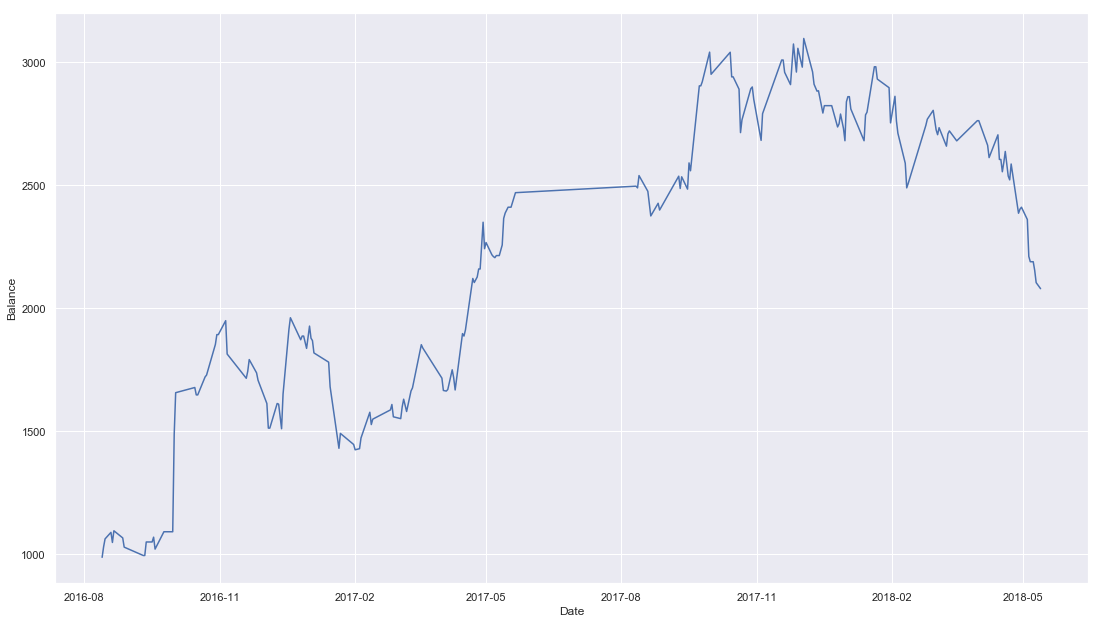

In [17]:
df_sim_2016_2017 = naive_method(fixtures_2016)
df_sim_2016_2017 = df_sim_2016_2017.append(naive_method(fixtures, df_sim_2016_2017['Balance'].values[-1]))
%matplotlib inline
import seaborn as sns
sns.set()
g = sns.lineplot(data=df_sim_2016_2017, x='Date', y='Balance')
g.figure.set_size_inches(18.5, 10.5)

Starting balance: 1000
2016-08-13 Pay: -50 on West Brom in [ Crystal Palace vs West Brom ] Pred: Win Actual: Win Balance: 950
2016-08-13 Receive: 225.0 Odd: 4.5 Balance: 1175.0
2016-08-13 Pay: -50 on Everton in [ Everton vs Tottenham ] Pred: Lose Actual: Draw Balance: 1125.0
2016-08-13 Pay: -50 on Leicester in [ Hull vs Leicester ] Pred: Win Actual: Lose Balance: 1075.0
2016-08-13 Pay: -50 on Man City in [ Man City vs Sunderland ] Pred: Win Actual: Win Balance: 1025.0
2016-08-13 Receive: 62.5 Odd: 1.25 Balance: 1087.5
2016-08-13 Pay: -50 on Stoke in [ Middlesbrough vs Stoke ] Pred: Lose Actual: Draw Balance: 1037.5
2016-08-13 Pay: -50 on Southampton in [ Southampton vs Watford ] Pred: Win Actual: Draw Balance: 987.5
2016-08-14 Pay: -50 on Man United in [ Bournemouth vs Man United ] Pred: Win Actual: Win Balance: 937.5
2016-08-14 Receive: 92.5 Odd: 1.85 Balance: 1030.0
2016-08-15 Pay: -50 on Chelsea in [ Chelsea vs West Ham ] Pred: Win Actual: Win Balance: 980.0
2016-08-15 Receive: 82.5

2016-11-06 Pay: -50 on Liverpool in [ Liverpool vs Watford ] Pred: Win Actual: Win Balance: 1899.0
2016-11-06 Receive: 64.5 Odd: 1.29 Balance: 1963.5
2016-11-06 Pay: -50 on Arsenal in [ Arsenal vs Tottenham ] Pred: Win Actual: Draw Balance: 1913.5
2016-11-06 Pay: -50 on Southampton in [ Hull vs Southampton ] Pred: Win Actual: Lose Balance: 1863.5
2016-11-06 Pay: -50 on Leicester in [ Leicester vs West Brom ] Pred: Win Actual: Lose Balance: 1813.5
2016-11-19 Pay: -50 on Tottenham in [ Tottenham vs West Ham ] Pred: Win Actual: Win Balance: 1763.5
2016-11-19 Receive: 75.0 Odd: 1.5 Balance: 1838.5
2016-11-19 Pay: -50 on Man City in [ Crystal Palace vs Man City ] Pred: Win Actual: Win Balance: 1788.5
2016-11-19 Receive: 76.5 Odd: 1.53 Balance: 1865.0
2016-11-19 Pay: -50 on Arsenal in [ Man United vs Arsenal ] Pred: Lose Actual: Draw Balance: 1815.0
2016-11-19 Pay: -50 on Liverpool in [ Southampton vs Liverpool ] Pred: Lose Actual: Draw Balance: 1765.0
2016-11-19 Pay: -50 on Bournemouth in [

2017-01-15 Pay: -50 on Liverpool in [ Man United vs Liverpool ] Pred: Lose Actual: Draw Balance: 1730.5
2017-01-15 Pay: -50 on Everton in [ Everton vs Man City ] Pred: Lose Actual: Win Balance: 1680.5
2017-01-21 Pay: -50 on West Brom in [ West Brom vs Sunderland ] Pred: Draw Actual: Win Balance: 1630.5
2017-01-21 Pay: -50 on West Ham in [ Middlesbrough vs West Ham ] Pred: Lose Actual: Win Balance: 1580.5
2017-01-21 Pay: -50 on Liverpool in [ Liverpool vs Swansea ] Pred: Win Actual: Lose Balance: 1530.5
2017-01-21 Pay: -50 on Crystal Palace in [ Crystal Palace vs Everton ] Pred: Draw Actual: Lose Balance: 1480.5
2017-01-21 Pay: -50 on Man City in [ Man City vs Tottenham ] Pred: Win Actual: Draw Balance: 1430.5
2017-01-22 Pay: -50 on Arsenal in [ Arsenal vs Burnley ] Pred: Win Actual: Win Balance: 1380.5
2017-01-22 Receive: 60.0 Odd: 1.2 Balance: 1440.5
2017-01-22 Pay: -50 on Chelsea in [ Chelsea vs Hull ] Pred: Win Actual: Win Balance: 1390.5
2017-01-22 Receive: 59.0 Odd: 1.18 Balance: 

2017-04-08 Pay: -50 on Southampton in [ West Brom vs Southampton ] Pred: Win Actual: Win Balance: 1622.0
2017-04-08 Receive: 127.49999999999999 Odd: 2.55 Balance: 1749.5
2017-04-09 Pay: -50 on Man United in [ Sunderland vs Man United ] Pred: Win Actual: Win Balance: 1699.5
2017-04-09 Receive: 68.0 Odd: 1.36 Balance: 1767.5
2017-04-09 Pay: -50 on Everton in [ Everton vs Leicester ] Pred: Draw Actual: Win Balance: 1717.5
2017-04-10 Pay: -50 on Arsenal in [ Crystal Palace vs Arsenal ] Pred: Win Actual: Lose Balance: 1667.5
2017-04-15 Pay: -50 on Everton in [ Everton vs Burnley ] Pred: Win Actual: Win Balance: 1617.5
2017-04-15 Receive: 70.0 Odd: 1.4 Balance: 1687.5
2017-04-15 Pay: -50 on Man City in [ Southampton vs Man City ] Pred: Win Actual: Win Balance: 1637.5
2017-04-15 Receive: 86.5 Odd: 1.73 Balance: 1724.0
2017-04-15 Pay: -50 on Stoke in [ Stoke vs Hull ] Pred: Win Actual: Win Balance: 1674.0
2017-04-15 Receive: 97.5 Odd: 1.95 Balance: 1771.5
2017-04-15 Pay: -50 on West Ham in [ S

2017-09-09 Pay: -50 on Southampton in [ Southampton vs Watford ] Pred: Win Actual: Lose Balance: 869.5
2017-09-09 Pay: -50 on Man City in [ Man City vs Liverpool ] Pred: Win Actual: Win Balance: 819.5
2017-09-09 Receive: 92.5 Odd: 1.85 Balance: 912.0
2017-09-09 Pay: -50 on Tottenham in [ Everton vs Tottenham ] Pred: Win Actual: Win Balance: 862.0
2017-09-09 Receive: 105.0 Odd: 2.1 Balance: 967.0
2017-09-09 Pay: -50 on West Brom in [ Brighton vs West Brom ] Pred: Lose Actual: Lose Balance: 917.0
2017-09-09 Receive: 150.0 Odd: 3.0 Balance: 1067.0
2017-09-10 Pay: -50 on Swansea in [ Swansea vs Newcastle ] Pred: Win Actual: Lose Balance: 1017.0
2017-09-11 Pay: -50 on West Ham in [ West Ham vs Huddersfield ] Pred: Win Actual: Win Balance: 967.0
2017-09-11 Receive: 97.5 Odd: 1.95 Balance: 1064.5
2017-09-15 Pay: -50 on Bournemouth in [ Bournemouth vs Brighton ] Pred: Draw Actual: Win Balance: 1014.5
2017-09-16 Pay: -50 on Swansea in [ Tottenham vs Swansea ] Pred: Lose Actual: Draw Balance: 96

2017-11-28 Pay: -50 on Leicester in [ Leicester vs Tottenham ] Pred: Lose Actual: Win Balance: 1540.0
2017-11-28 Pay: -50 on West Brom in [ West Brom vs Newcastle ] Pred: Win Actual: Draw Balance: 1490.0
2017-11-29 Pay: -50 on Man City in [ Man City vs Southampton ] Pred: Win Actual: Win Balance: 1440.0
2017-11-29 Receive: 59.5 Odd: 1.19 Balance: 1499.5
2017-11-29 Pay: -50 on Everton in [ Everton vs West Ham ] Pred: Win Actual: Win Balance: 1449.5
2017-11-29 Receive: 118.5 Odd: 2.37 Balance: 1568.0
2017-11-29 Pay: -50 on Chelsea in [ Chelsea vs Swansea ] Pred: Win Actual: Win Balance: 1518.0
2017-11-29 Receive: 59.0 Odd: 1.18 Balance: 1577.0
2017-11-29 Pay: -50 on Arsenal in [ Arsenal vs Huddersfield ] Pred: Win Actual: Win Balance: 1527.0
2017-11-29 Receive: 59.5 Odd: 1.19 Balance: 1586.5
2017-12-02 Pay: -50 on Tottenham in [ Watford vs Tottenham ] Pred: Win Actual: Draw Balance: 1536.5
2017-12-02 Pay: -50 on Crystal Palace in [ West Brom vs Crystal Palace ] Pred: Lose Actual: Draw Ba

2018-01-20 Receive: 75.0 Odd: 1.5 Balance: 1511.5
2018-01-22 Pay: -50 on Liverpool in [ Swansea vs Liverpool ] Pred: Win Actual: Lose Balance: 1461.5
2018-01-30 Pay: -50 on Liverpool in [ Huddersfield vs Liverpool ] Pred: Win Actual: Win Balance: 1411.5
2018-01-30 Receive: 65.0 Odd: 1.3 Balance: 1476.5
2018-01-30 Pay: -50 on Arsenal in [ Swansea vs Arsenal ] Pred: Win Actual: Lose Balance: 1426.5
2018-01-31 Pay: -50 on Southampton in [ Southampton vs Brighton ] Pred: Win Actual: Draw Balance: 1376.5
2018-01-31 Pay: -50 on Man City in [ Man City vs West Brom ] Pred: Win Actual: Win Balance: 1326.5
2018-01-31 Receive: 56.99999999999999 Odd: 1.14 Balance: 1383.5
2018-01-31 Pay: -50 on Bournemouth in [ Chelsea vs Bournemouth ] Pred: Lose Actual: Win Balance: 1333.5
2018-01-31 Pay: -50 on Burnley in [ Newcastle vs Burnley ] Pred: Lose Actual: Draw Balance: 1283.5
2018-02-03 Pay: -50 on Man United in [ Man United vs Huddersfield ] Pred: Win Actual: Win Balance: 1233.5
2018-02-03 Receive: 57.

2018-05-06 Pay: -50 on Man City in [ Man City vs Huddersfield ] Pred: Win Actual: Draw Balance: 719.5
2018-05-09 Pay: -50 on Chelsea in [ Chelsea vs Huddersfield ] Pred: Win Actual: Draw Balance: 669.5
2018-05-09 Pay: -50 on Man City in [ Man City vs Brighton ] Pred: Win Actual: Win Balance: 619.5
2018-05-09 Receive: 56.00000000000001 Odd: 1.12 Balance: 675.5
2018-05-09 Pay: -50 on Tottenham in [ Tottenham vs Newcastle ] Pred: Win Actual: Win Balance: 625.5
2018-05-09 Receive: 59.0 Odd: 1.18 Balance: 684.5
2018-05-10 Pay: -50 on Man United in [ West Ham vs Man United ] Pred: Win Actual: Draw Balance: 634.5
2018-05-13 Pay: -50 on Chelsea in [ Newcastle vs Chelsea ] Pred: Win Actual: Lose Balance: 584.5
2018-05-13 Pay: -50 on Man United in [ Man United vs Watford ] Pred: Win Actual: Win Balance: 534.5
2018-05-13 Receive: 69.5 Odd: 1.39 Balance: 604.0
2018-05-13 Pay: -50 on Tottenham in [ Tottenham vs Leicester ] Pred: Win Actual: Win Balance: 554.0
2018-05-13 Receive: 66.5 Odd: 1.33 Bala

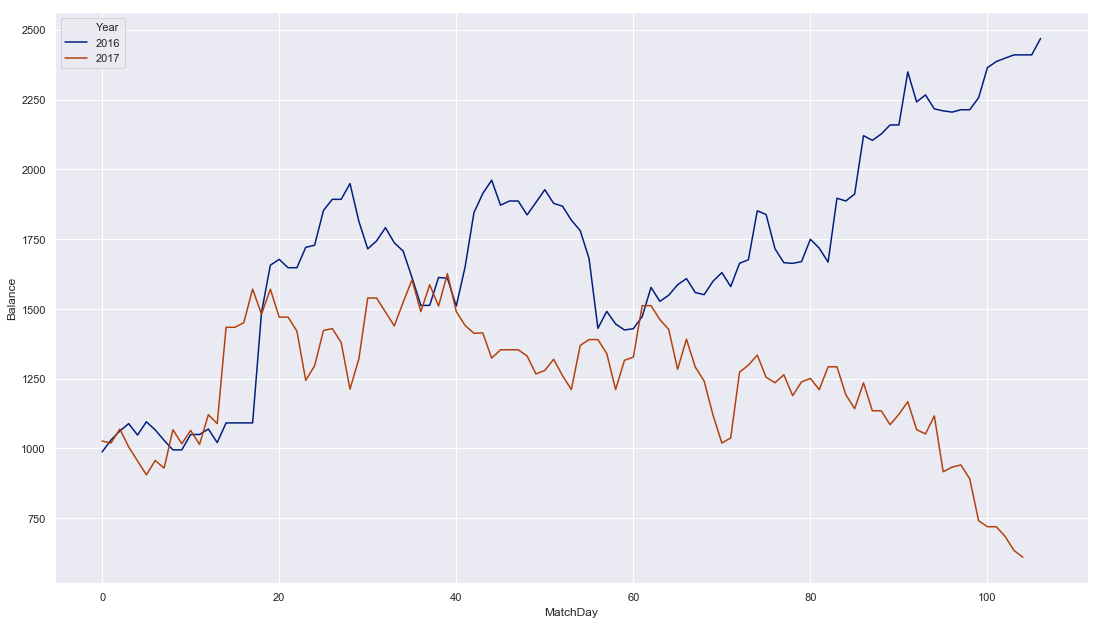

In [18]:
df_sim_all = naive_method(fixtures_2016)
df_sim_all = df_sim_all.append(naive_method(fixtures))
%matplotlib inline
import seaborn as sns
sns.set()
g = sns.lineplot(data=df_sim_all, x='MatchDay', y='Balance', hue='Year', palette=sns.color_palette("dark", 2))
g.figure.set_size_inches(18.5, 10.5)

In [19]:
df_sim_all[df_sim_all['Year'] == 2016]

,Date,Balance,Year,MatchDay
0,2016-08-13,987.5,2016,0
1,2016-08-14,1030.0,2016,1
2,2016-08-15,1062.5,2016,2
3,2016-08-19,1089.0,2016,3
4,2016-08-20,1048.0,2016,4
5,2016-08-21,1095.5,2016,5
6,2016-08-27,1066.5,2016,6
7,2016-08-28,1029.0,2016,7
8,2016-09-10,995.0,2016,8
9,2016-09-11,995.0,2016,9


In [111]:
import datetime
def next_draw_method(fixtures, starting_balance=1000):
#     starting_balance = 1000
    balance = starting_balance
    bet = -50
    balances = [1000]
    dates = [datetime.datetime(fixtures['Date'].iloc[0].year,8,1)]
    receives = [0]
    bets = [0]
    profits = [0]
    print("Starting balance:", balance)
    for date, groupByDate in fixtures.groupby('Date'):
        bet_today = 0
        receive_today = 0
        for _, match in groupByDate.iterrows():
    #         print(match['index'])
            d = date.date().strftime('%Y-%m-%d')
            predictions = total[total.index == match['index']]
            if (len(predictions) == 1):
    #             prediction = predictions[:,0]
    #             print(predictions)
                team = predictions['Team'].values[0]
                pred = predictions['Predict'].values[0]
                act = predictions['Actual'].values[0]
                balance += bet
                bet_today += bet
                print(d, "Pay:", bet, 'on', team, 'in [', match['HomeTeam'], 'vs', match['AwayTeam'], "] Pred:", pred, "Actual:", act, 'Balance:', balance)
                
                odd = 0
                if pred == act:
    #                 print(match)
                    if pred == act == 'Draw':
                        odd = match['B365D']
                    elif match['HomeTeam'] == team:
                        odd = match['B365H']
                    else:
                        odd = match['B365A']
                    receive = bet * odd * -1
                    balance += receive
                    receive_today += receive
                    print(d, "Receive:", receive, "Odd:", odd, "Balance:", balance)
            elif (len(predictions) == 2):
    #             print(predictions)
    #             print(match)
                pred = ''
                act = ''
                pred_one = predictions['Predict'].values[0]
                pred_two = predictions['Predict'].values[1]
                act_one = predictions['Actual'].values[0]
                act_two = predictions['Actual'].values[1]
    #             print(team, "Pred: ", pred, "Actual:", act)
                odd = 0
                # unanimousness
                if (pred_one == pred_two == 'Draw') or\
                (pred_one == 'Win' and pred_two == 'Lose') or\
                (pred_one == 'Lose' and pred_two == 'Win'):

#                     balance += bet
#                     print('what', len(predictions), balance)
#                     print(match)
#                     odd = 0

                    if pred_one == pred_two == act_one == act_two == 'Draw':
                        team = predictions['Team'].values[0]
                        odd = match['B365D']
                        pred = pred_one
                        act = act_one
#                         print(d, "Pay:", bet, 'on', team, 'in [', match['HomeTeam'], 'vs', match['AwayTeam'], "] Pred:", pred, "Actual:", act, 'Balance:', balance)

                    elif pred_one == act_one == 'Win' and pred_two == act_two == 'Lose':
                        team = predictions['Team'].values[0]
                        if match['HomeTeam'] == team:
                            odd = match['B365H']
                        else:
                            odd = match['B365A']
                        pred = pred_one
                        act = act_one
#                         print(d, "Pay:", bet, 'on', team, 'in [', match['HomeTeam'], 'vs', match['AwayTeam'], "] Pred:", pred_one, "Actual:", act_one, 'Balance:', balance)

                    elif pred_one == act_one == 'Lose' and pred_two == act_two == 'Win':
                        team = predictions['Team'].values[1]
                        if match['HomeTeam'] == team:
                            odd = match['B365H']
                        else:
                            odd = match['B365A']
                        pred = pred_two
                        act = act_two
#                         print(d, "Pay:", bet, 'on', team, 'in [', match['HomeTeam'], 'vs', match['AwayTeam'], "] Pred:", pred_two, "Actual:", act_two, 'Balance:', balance)
                    else:
                        team = predictions['Team'].values[0]
#                         print(d, "Pay:", bet, 'on', team, 'in [', match['HomeTeam'], 'vs', match['AwayTeam'], "] Pred:", pred_one, "Actual:", act_one, 'Balance:', balance)
                elif pred_one == 'Draw' or pred_two == 'Draw':
                    # if one of them predict Draw but the other does not, find next best
                    if pred_one == 'Draw':
                        lose_prob_two = predictions['LoseProb'].values[1]
                        win_prob_two = predictions['WinProb'].values[1]
                        if lose_prob_two > win_prob_two:
                            # guess a draw
                            team = predictions['Team'].values[0]
                            pred = 'Draw'
                            if act_one == 'Draw':
                                odd = match['B365D']
#                         else:
#                             # do nothing
#                             pass
                    else:
                        lose_prob_one = predictions['LoseProb'].values[0]
                        win_prob_one = predictions['WinProb'].values[0]
                        if lose_prob_one > win_prob_one:
                            # guess a draw
                            team = predictions['Team'].values[1]
                            pred = 'Draw'
                            if act_one == 'Draw':
                                odd = match['B365D']
                elif pred_one == pred_two == 'Lose':
                    # if both are losers, bet on draw
                    team = predictions['Team'].values[0]
                    pred = 'Draw'
                    if act_one == 'Draw':
                        odd = match['B365D']
                    act = act_one
                if pred != '':
                    balance += bet
                    bet_today += bet
                    print(d, "Pay:", bet, 'on', team, 'in [', match['HomeTeam'], 'vs', match['AwayTeam'], "] Pred:", pred, "Actual:", act, 'Balance:', balance)
                else:
                    print(d, "No bet in [", match['HomeTeam'], 'vs', match['AwayTeam'], "] Balance:", balance)
                    
                if odd != 0:
                    receive = bet * odd * -1
                    balance += receive
                    receive_today += receive
                    print(d, "Receive:", receive, "Odd:", odd, "Balance:", balance)
                

            else:
                print(d, "No bet in [", match['HomeTeam'], 'vs', match['AwayTeam'], "] Balance:", balance)
    #             print(predictions)
        balances.append(balance)
        dates.append(date)
        receives.append(receive_today)
        bets.append(bet_today)
        profits.append(receive_today + bet_today)
    print("Ending balance:", balance)
    year = dates[0].date().year
    df_sim = pd.DataFrame(
    data={
        'Date': dates,
        'Balance': balances,
        'Year': year,
        'MatchDay': range(1, len(dates) + 1),
        'Receive': receives,
        'Bet': bets,
        'Profit': profits
    })
    return df_sim

In [112]:
df_sim_nd_2017 = next_draw_method(fixtures)

Starting balance: 1000
2017-08-11 Pay: -50 on Arsenal in [ Arsenal vs Leicester ] Pred: Win Actual: Win Balance: 950
2017-08-11 Receive: 76.5 Odd: 1.53 Balance: 1026.5
2017-08-12 Pay: -50 on Man City in [ Brighton vs Man City ] Pred: Win Actual: Win Balance: 976.5
2017-08-12 Receive: 66.5 Odd: 1.33 Balance: 1043.0
2017-08-12 No bet in [ Chelsea vs Burnley ] Balance: 1043.0
2017-08-12 Pay: -50 on Crystal Palace in [ Crystal Palace vs Huddersfield ] Pred: Lose Actual: Lose Balance: 993.0
2017-08-12 Receive: 91.5 Odd: 1.83 Balance: 1084.5
2017-08-12 Pay: -50 on Everton in [ Everton vs Stoke ] Pred: Win Actual: Win Balance: 1034.5
2017-08-12 Receive: 85.0 Odd: 1.7 Balance: 1119.5
2017-08-12 No bet in [ Southampton vs Swansea ] Balance: 1119.5
2017-08-12 No bet in [ Watford vs Liverpool ] Balance: 1119.5
2017-08-12 Pay: -50 on Bournemouth in [ West Brom vs Bournemouth ] Pred: Draw Actual: Lose Balance: 1069.5
2017-08-13 Pay: -50 on Man United in [ Man United vs West Ham ] Pred: Win Actual: 

2017-10-15 Pay: -50 on Everton in [ Brighton vs Everton ] Pred: Win Actual: Draw Balance: 2133.0
2017-10-15 Pay: -50 on Southampton in [ Southampton vs Newcastle ] Pred: Win Actual: Draw Balance: 2083.0
2017-10-16 No bet in [ Leicester vs West Brom ] Balance: 2083.0
2017-10-20 Pay: -50 on West Ham in [ West Ham vs Brighton ] Pred: Win Actual: Lose Balance: 2033.0
2017-10-21 Pay: -50 on Chelsea in [ Chelsea vs Watford ] Pred: Win Actual: Win Balance: 1983.0
2017-10-21 Receive: 68.0 Odd: 1.36 Balance: 2051.0
2017-10-21 Pay: -50 on Man United in [ Huddersfield vs Man United ] Pred: Win Actual: Lose Balance: 2001.0
2017-10-21 Pay: -50 on Man City in [ Man City vs Burnley ] Pred: Win Actual: Win Balance: 1951.0
2017-10-21 Receive: 55.50000000000001 Odd: 1.11 Balance: 2006.5
2017-10-21 Pay: -50 on Crystal Palace in [ Newcastle vs Crystal Palace ] Pred: Draw Actual: Lose Balance: 1956.5
2017-10-21 No bet in [ Southampton vs West Brom ] Balance: 1956.5
2017-10-21 No bet in [ Stoke vs Bournemou

2017-12-16 Pay: -50 on Man City in [ Man City vs Tottenham ] Pred: Win Actual: Win Balance: 2508.5
2017-12-16 Receive: 77.5 Odd: 1.55 Balance: 2586.0
2017-12-16 No bet in [ Stoke vs West Ham ] Balance: 2586.0
2017-12-16 Pay: -50 on Watford in [ Watford vs Huddersfield ] Pred: Win Actual: Lose Balance: 2536.0
2017-12-17 Pay: -50 on Man United in [ West Brom vs Man United ] Pred: Win Actual: Win Balance: 2486.0
2017-12-17 Receive: 80.0 Odd: 1.6 Balance: 2566.0
2017-12-17 No bet in [ Bournemouth vs Liverpool ] Balance: 2566.0
2017-12-18 No bet in [ Everton vs Swansea ] Balance: 2566.0
2017-12-22 No bet in [ Arsenal vs Liverpool ] Balance: 2566.0
2017-12-23 No bet in [ Stoke vs West Brom ] Balance: 2566.0
2017-12-23 Pay: -50 on Southampton in [ Southampton vs Huddersfield ] Pred: Draw Actual: Draw Balance: 2516.0
2017-12-23 Receive: 194.5 Odd: 3.89 Balance: 2710.5
2017-12-23 No bet in [ Swansea vs Crystal Palace ] Balance: 2710.5
2017-12-23 Pay: -50 on Man City in [ Man City vs Bournemouth

2018-03-01 Pay: -50 on Man City in [ Arsenal vs Man City ] Pred: Win Actual: Win Balance: 3615.5
2018-03-01 Receive: 86.0 Odd: 1.72 Balance: 3701.5
2018-03-03 No bet in [ Swansea vs West Ham ] Balance: 3701.5
2018-03-03 Pay: -50 on Tottenham in [ Tottenham vs Huddersfield ] Pred: Win Actual: Win Balance: 3651.5
2018-03-03 Receive: 59.5 Odd: 1.19 Balance: 3711.0
2018-03-03 No bet in [ Watford vs West Brom ] Balance: 3711.0
2018-03-03 Pay: -50 on Liverpool in [ Liverpool vs Newcastle ] Pred: Win Actual: Win Balance: 3661.0
2018-03-03 Receive: 61.0 Odd: 1.22 Balance: 3722.0
2018-03-03 No bet in [ Leicester vs Bournemouth ] Balance: 3722.0
2018-03-03 No bet in [ Southampton vs Stoke ] Balance: 3722.0
2018-03-03 No bet in [ Burnley vs Everton ] Balance: 3722.0
2018-03-04 Pay: -50 on Arsenal in [ Brighton vs Arsenal ] Pred: Win Actual: Lose Balance: 3672.0
2018-03-04 Pay: -50 on Man City in [ Man City vs Chelsea ] Pred: Win Actual: Win Balance: 3622.0
2018-03-04 Receive: 80.5 Odd: 1.61 Balan

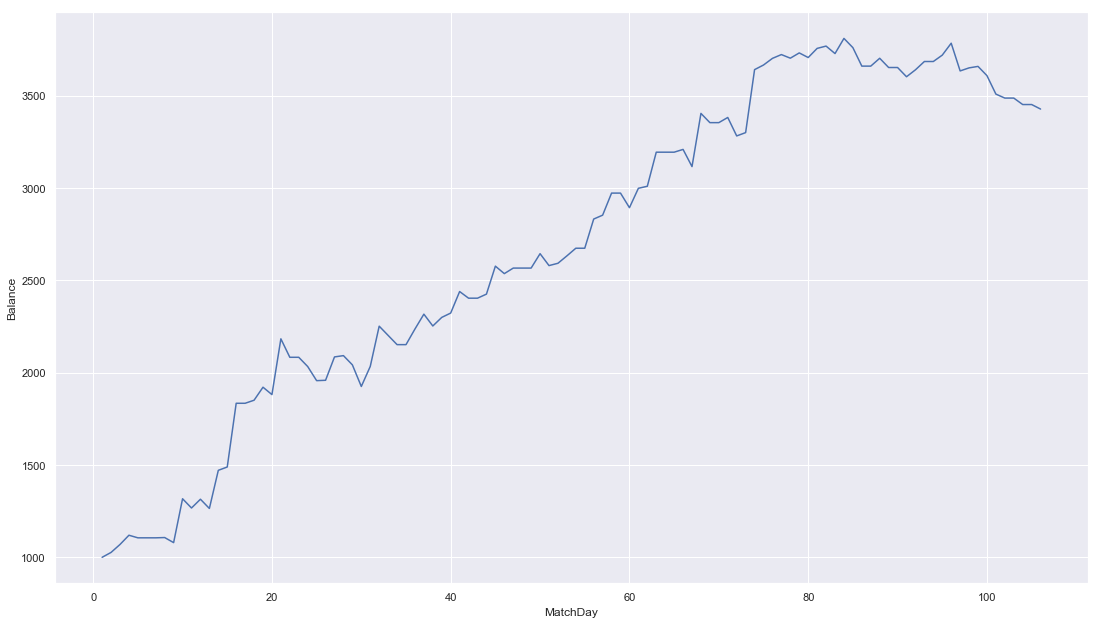

In [113]:

%matplotlib inline
import seaborn as sns
sns.set()
g = sns.lineplot(data=df_sim_nd_2017, x='MatchDay', y='Balance')
g.figure.set_size_inches(18.5, 10.5)

In [114]:
df_sim_nd_2016 = next_draw_method(fixtures_2016)

Starting balance: 1000
2016-08-13 Pay: -50 on Burnley in [ Burnley vs Swansea ] Pred: Draw Actual:  Balance: 950
2016-08-13 Pay: -50 on West Brom in [ Crystal Palace vs West Brom ] Pred: Win Actual: Win Balance: 900
2016-08-13 Receive: 225.0 Odd: 4.5 Balance: 1125.0
2016-08-13 No bet in [ Everton vs Tottenham ] Balance: 1125.0
2016-08-13 Pay: -50 on Leicester in [ Hull vs Leicester ] Pred: Win Actual: Lose Balance: 1075.0
2016-08-13 Pay: -50 on Man City in [ Man City vs Sunderland ] Pred: Win Actual: Win Balance: 1025.0
2016-08-13 Receive: 62.5 Odd: 1.25 Balance: 1087.5
2016-08-13 Pay: -50 on Stoke in [ Middlesbrough vs Stoke ] Pred: Lose Actual: Draw Balance: 1037.5
2016-08-13 No bet in [ Southampton vs Watford ] Balance: 1037.5
2016-08-14 No bet in [ Arsenal vs Liverpool ] Balance: 1037.5
2016-08-14 Pay: -50 on Man United in [ Bournemouth vs Man United ] Pred: Win Actual: Win Balance: 987.5
2016-08-14 Receive: 92.5 Odd: 1.85 Balance: 1080.0
2016-08-15 Pay: -50 on Chelsea in [ Chelsea

2016-11-05 Pay: -50 on Man City in [ Man City vs Middlesbrough ] Pred: Win Actual: Draw Balance: 2359.0
2016-11-05 Pay: -50 on Stoke in [ West Ham vs Stoke ] Pred: Draw Actual: Draw Balance: 2309.0
2016-11-05 Receive: 180.0 Odd: 3.6 Balance: 2489.0
2016-11-06 No bet in [ Swansea vs Man United ] Balance: 2489.0
2016-11-06 Pay: -50 on Liverpool in [ Liverpool vs Watford ] Pred: Win Actual: Win Balance: 2439.0
2016-11-06 Receive: 64.5 Odd: 1.29 Balance: 2503.5
2016-11-06 No bet in [ Arsenal vs Tottenham ] Balance: 2503.5
2016-11-06 Pay: -50 on Southampton in [ Hull vs Southampton ] Pred: Win Actual: Lose Balance: 2453.5
2016-11-06 No bet in [ Leicester vs West Brom ] Balance: 2453.5
2016-11-19 Pay: -50 on Tottenham in [ Tottenham vs West Ham ] Pred: Win Actual: Win Balance: 2403.5
2016-11-19 Receive: 75.0 Odd: 1.5 Balance: 2478.5
2016-11-19 Pay: -50 on Man City in [ Crystal Palace vs Man City ] Pred: Win Actual: Win Balance: 2428.5
2016-11-19 Receive: 76.5 Odd: 1.53 Balance: 2505.0
2016-1

2017-01-14 No bet in [ Swansea vs Arsenal ] Balance: 3139.5
2017-01-14 Pay: -50 on Stoke in [ Sunderland vs Stoke ] Pred: Draw Actual: Win Balance: 3089.5
2017-01-14 Pay: -50 on Burnley in [ Burnley vs Southampton ] Pred: Draw Actual: Win Balance: 3039.5
2017-01-14 Pay: -50 on Bournemouth in [ Hull vs Bournemouth ] Pred: Lose Actual: Lose Balance: 2989.5
2017-01-14 Receive: 114.99999999999999 Odd: 2.3 Balance: 3104.5
2017-01-14 Pay: -50 on Watford in [ Watford vs Middlesbrough ] Pred: Win Actual: Draw Balance: 3054.5
2017-01-14 Pay: -50 on Chelsea in [ Leicester vs Chelsea ] Pred: Win Actual: Win Balance: 3004.5
2017-01-14 Receive: 81.0 Odd: 1.62 Balance: 3085.5
2017-01-14 No bet in [ West Ham vs Crystal Palace ] Balance: 3085.5
2017-01-15 No bet in [ Man United vs Liverpool ] Balance: 3085.5
2017-01-15 No bet in [ Everton vs Man City ] Balance: 3085.5
2017-01-21 Pay: -50 on West Brom in [ West Brom vs Sunderland ] Pred: Draw Actual: Win Balance: 3035.5
2017-01-21 Pay: -50 on Stoke in 

2017-04-05 Pay: -50 on Tottenham in [ Swansea vs Tottenham ] Pred: Win Actual: Win Balance: 4318.0
2017-04-05 Receive: 86.5 Odd: 1.73 Balance: 4404.5
2017-04-05 No bet in [ Southampton vs Crystal Palace ] Balance: 4404.5
2017-04-05 No bet in [ Liverpool vs Bournemouth ] Balance: 4404.5
2017-04-05 No bet in [ Chelsea vs Man City ] Balance: 4404.5
2017-04-05 Pay: -50 on Arsenal in [ Arsenal vs West Ham ] Pred: Win Actual: Win Balance: 4354.5
2017-04-05 Receive: 70.0 Odd: 1.4 Balance: 4424.5
2017-04-05 No bet in [ Hull vs Middlesbrough ] Balance: 4424.5
2017-04-08 Pay: -50 on Chelsea in [ Bournemouth vs Chelsea ] Pred: Win Actual: Win Balance: 4374.5
2017-04-08 Receive: 80.0 Odd: 1.6 Balance: 4454.5
2017-04-08 Pay: -50 on Man City in [ Man City vs Hull ] Pred: Win Actual: Win Balance: 4404.5
2017-04-08 Receive: 60.0 Odd: 1.2 Balance: 4464.5
2017-04-08 Pay: -50 on Burnley in [ Middlesbrough vs Burnley ] Pred: Lose Actual: Draw Balance: 4414.5
2017-04-08 No bet in [ Stoke vs Liverpool ] Bal

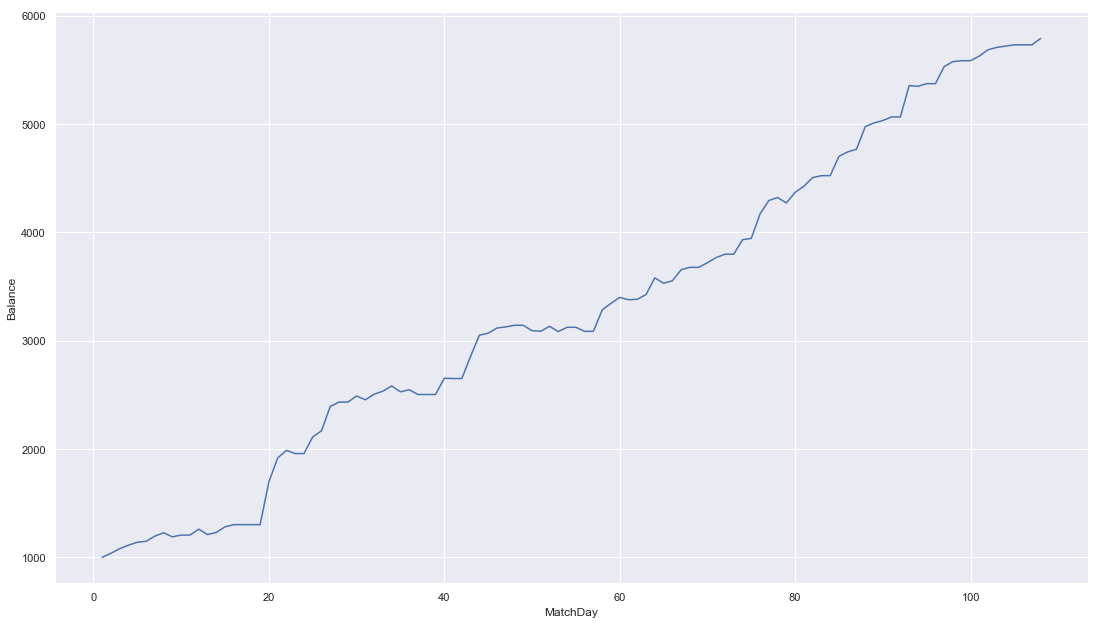

In [115]:

%matplotlib inline
import seaborn as sns
sns.set()
g = sns.lineplot(data=df_sim_nd_2016, x='MatchDay', y='Balance')
g.figure.set_size_inches(18.5, 10.5)

In [116]:
fixtures_2018 = pd.DataFrame(df[df['Year'] == 2018])
fixtures_2018['Date'] = pd.to_datetime(fixtures_2018['Date'], dayfirst=True)
fixtures_2018.sort_values(['Date'], inplace=True)
fixtures_2018

,index,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,Match,BSH,BSD,BSA,PSH,PSD,PSA,PSCH,PSCD,PSCA
4941,4941,E0,2018-08-10,Man United,Leicester,2.0,1.0,H,1.0,0.0,...,1,NaN,NaN,NaN,1.58,3.93,7.50,1.55,4.07,7.69
4942,4942,E0,2018-08-11,Bournemouth,Cardiff,2.0,0.0,H,1.0,0.0,...,2,NaN,NaN,NaN,1.89,3.63,4.58,1.88,3.61,4.70
4943,4943,E0,2018-08-11,Fulham,Crystal Palace,0.0,2.0,A,0.0,1.0,...,3,NaN,NaN,NaN,2.50,3.46,3.00,2.62,3.38,2.90
4944,4944,E0,2018-08-11,Huddersfield,Chelsea,0.0,3.0,A,0.0,2.0,...,4,NaN,NaN,NaN,6.41,4.02,1.62,7.24,3.95,1.58
4945,4945,E0,2018-08-11,Newcastle,Tottenham,1.0,2.0,A,1.0,2.0,...,5,NaN,NaN,NaN,3.83,3.57,2.08,4.74,3.53,1.89
4946,4946,E0,2018-08-11,Watford,Brighton,2.0,0.0,H,1.0,0.0,...,6,NaN,NaN,NaN,2.43,3.22,3.33,2.58,3.08,3.22
4947,4947,E0,2018-08-11,Wolves,Everton,2.0,2.0,D,1.0,1.0,...,7,NaN,NaN,NaN,2.36,3.40,3.28,2.44,3.23,3.32
4948,4948,E0,2018-08-12,Arsenal,Man City,0.0,2.0,A,0.0,1.0,...,8,NaN,NaN,NaN,4.00,3.97,1.93,4.43,4.13,1.81
4949,4949,E0,2018-08-12,Liverpool,West Ham,4.0,0.0,H,2.0,0.0,...,9,NaN,NaN,NaN,1.27,6.35,13.25,1.25,6.95,12.00
4950,4950,E0,2018-08-12,Southampton,Burnley,0.0,0.0,D,0.0,0.0,...,10,NaN,NaN,NaN,1.86,3.51,4.99,2.03,3.19,4.65


In [117]:
df_sim_nd_2018 = next_draw_method(fixtures_2018)
df_sim_nd_2018

Starting balance: 1000
2018-08-10 Pay: -50 on Man United in [ Man United vs Leicester ] Pred: Win Actual: Win Balance: 950
2018-08-10 Receive: 78.5 Odd: 1.57 Balance: 1028.5
2018-08-11 Pay: -50 on Bournemouth in [ Bournemouth vs Cardiff ] Pred: Draw Actual: Win Balance: 978.5
2018-08-11 Pay: -50 on Crystal Palace in [ Fulham vs Crystal Palace ] Pred: Win Actual: Win Balance: 928.5
2018-08-11 Receive: 150.0 Odd: 3.0 Balance: 1078.5
2018-08-11 Pay: -50 on Chelsea in [ Huddersfield vs Chelsea ] Pred: Win Actual: Win Balance: 1028.5
2018-08-11 Receive: 80.5 Odd: 1.61 Balance: 1109.0
2018-08-11 Pay: -50 on Tottenham in [ Newcastle vs Tottenham ] Pred: Win Actual: Win Balance: 1059.0
2018-08-11 Receive: 102.0 Odd: 2.04 Balance: 1161.0
2018-08-11 Pay: -50 on Watford in [ Watford vs Brighton ] Pred: Draw Actual: Win Balance: 1111.0
2018-08-11 Pay: -50 on Everton in [ Wolves vs Everton ] Pred: Lose Actual: Draw Balance: 1061.0
2018-08-12 Pay: -50 on Man City in [ Arsenal vs Man City ] Pred: Win

2018-10-06 Pay: -50 on Watford in [ Watford vs Bournemouth ] Pred: Draw Actual:  Balance: 1518.5
2018-10-06 Pay: -50 on Tottenham in [ Tottenham vs Cardiff ] Pred: Win Actual: Win Balance: 1468.5
2018-10-06 Receive: 61.0 Odd: 1.22 Balance: 1529.5
2018-10-06 Pay: -50 on Man United in [ Man United vs Newcastle ] Pred: Win Actual: Win Balance: 1479.5
2018-10-06 Receive: 72.0 Odd: 1.44 Balance: 1551.5
2018-10-06 Pay: -50 on Crystal Palace in [ Crystal Palace vs Wolves ] Pred: Lose Actual: Lose Balance: 1501.5
2018-10-06 Receive: 150.0 Odd: 3.0 Balance: 1651.5
2018-10-06 Pay: -50 on Burnley in [ Burnley vs Huddersfield ] Pred: Lose Actual: Draw Balance: 1601.5
2018-10-06 Pay: -50 on Leicester in [ Leicester vs Everton ] Pred: Draw Actual:  Balance: 1551.5
2018-10-07 Pay: -50 on Arsenal in [ Fulham vs Arsenal ] Pred: Win Actual: Win Balance: 1501.5
2018-10-07 Receive: 83.0 Odd: 1.66 Balance: 1584.5
2018-10-07 No bet in [ Liverpool vs Man City ] Balance: 1584.5
2018-10-07 Pay: -50 on Chelsea 

,Date,Balance,Year,MatchDay,Receive,Bet,Profit
0,2018-08-01,1000.0,2018,1,0.0,0,0.0
1,2018-08-10,1028.5,2018,2,78.5,-50,28.5
2,2018-08-11,1061.0,2018,3,332.5,-300,32.5
3,2018-08-12,1121.0,2018,4,160.0,-100,60.0
4,2018-08-18,1170.0,2018,5,249.0,-200,49.0
5,2018-08-19,1125.0,2018,6,55.0,-100,-45.0
6,2018-08-20,1147.0,2018,7,72.0,-50,22.0
7,2018-08-25,1073.0,2018,8,126.0,-200,-74.0
8,2018-08-26,1272.5,2018,9,299.5,-100,199.5
9,2018-08-27,1272.5,2018,10,0.0,0,0.0


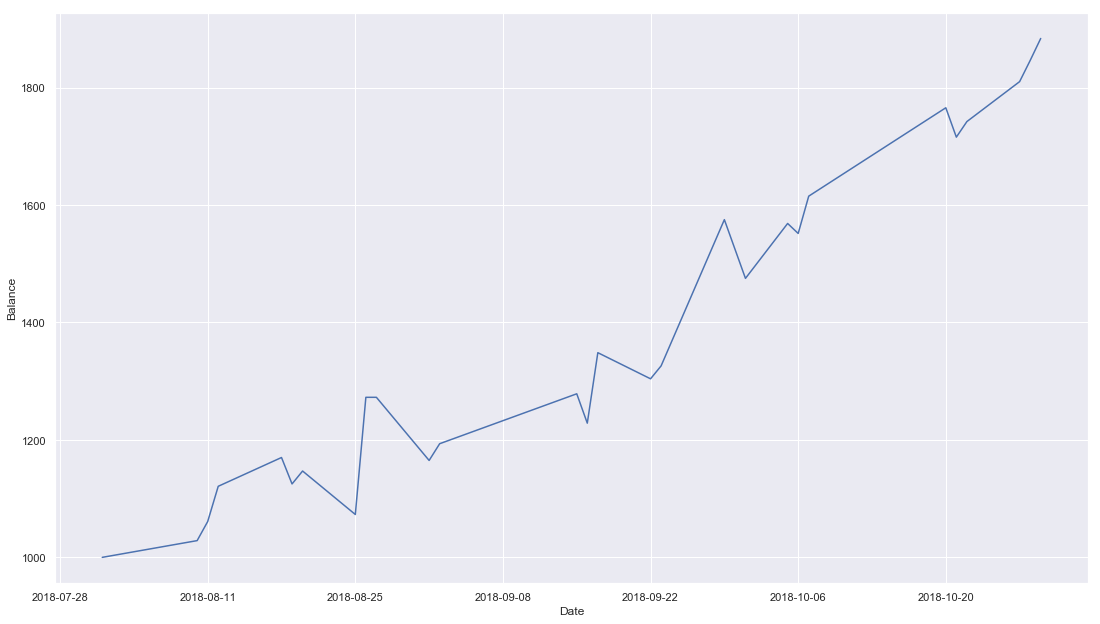

In [118]:
%matplotlib inline
import seaborn as sns
sns.set()
g = sns.lineplot(data=df_sim_nd_2018, x='Date', y='Balance')
g.figure.set_size_inches(18.5, 10.5)

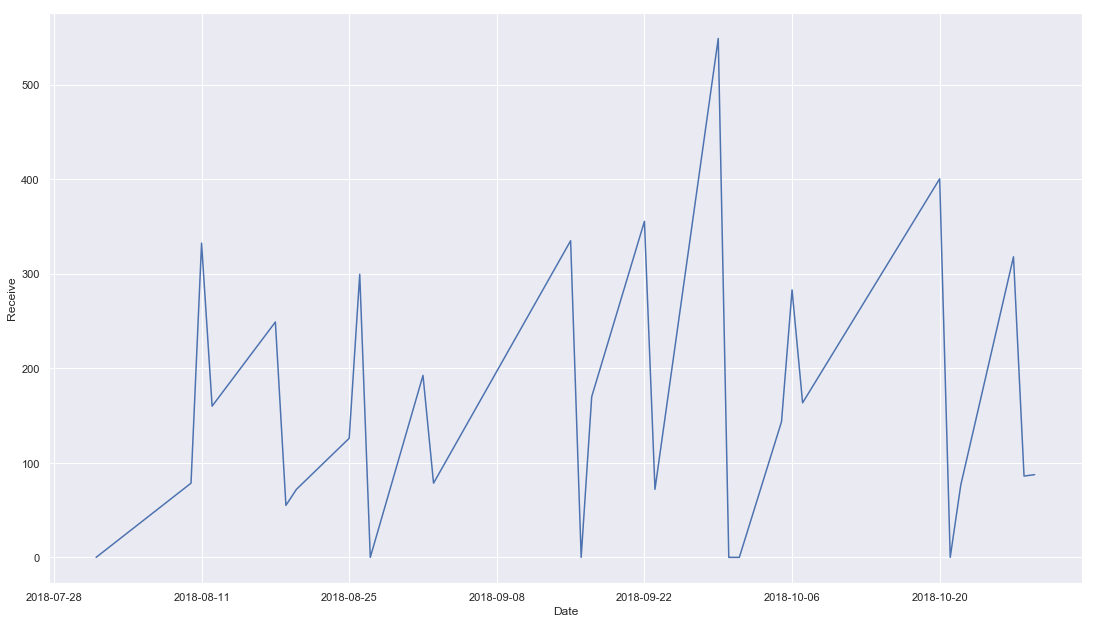

In [119]:
%matplotlib inline
import seaborn as sns
sns.set()
g = sns.lineplot(data=df_sim_nd_2018, x='Date', y='Receive')
g.figure.set_size_inches(18.5, 10.5)

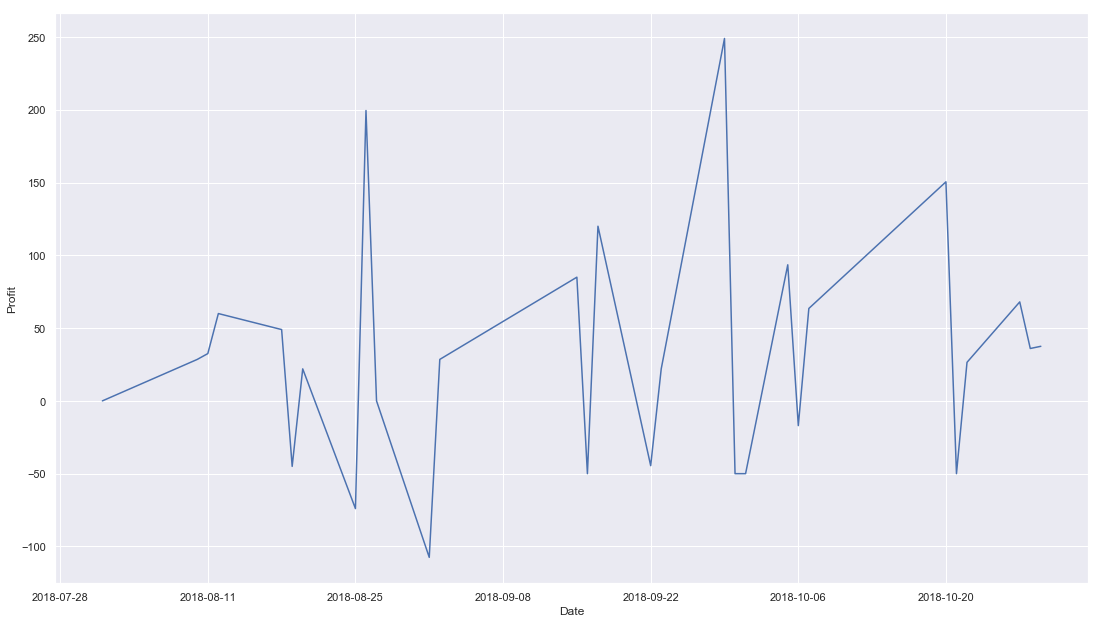

In [120]:
%matplotlib inline
import seaborn as sns
sns.set()
g = sns.lineplot(data=df_sim_nd_2018, x='Date', y='Profit')
g.figure.set_size_inches(18.5, 10.5)

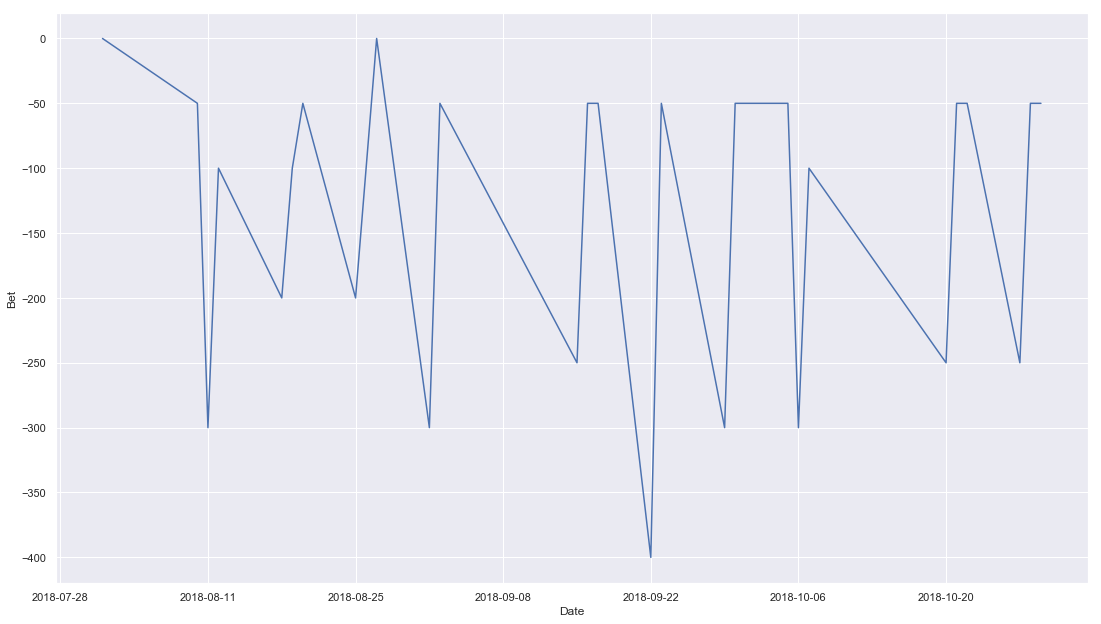

In [121]:
%matplotlib inline
import seaborn as sns
sns.set()
g = sns.lineplot(data=df_sim_nd_2018, x='Date', y='Bet')
g.figure.set_size_inches(18.5, 10.5)